# Compare lifetime maps and check evolution

### Notebook configuration

In [1]:
run_number_1          = 4628
run_number_2          = 4734
correction_filename_1 = f"$IC_DATA/XYmaps/corrections_run{run_number_1}.h5"
correction_filename_2 = f"$IC_DATA/XYmaps/corrections_run{run_number_2}.h5"

XY_pitch            = 5.0

# Plotting style
default_cmap        = "jet"
figure_size         = 18, 12
font_size           = 17
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = True
with_titles         = False
plots_format        = "pdf"

### Imports

In [2]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string
from invisible_cities.icaro.hst_functions import labels

Running on  Thu Nov 16 12:49:49 2017


### Initialization

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [4]:
correction_filename_1 = os.path.expandvars(correction_filename_1)
correction_filename_2 = os.path.expandvars(correction_filename_2)

In [5]:
LT_correction_1  = dstf.load_lifetime_xy_corrections(correction_filename_1,
                                                     group = "XYcorrections",
                                                     node  = "Lifetime")

LT_correction_2  = dstf.load_lifetime_xy_corrections(correction_filename_2,
                                                     group = "XYcorrections",
                                                     node  = "Lifetime")

GEO_correction_1 = dstf.load_xy_corrections(correction_filename_1,
                                            group         =  "XYcorrections",
                                            node          = f"Geometry_{XY_pitch:.1f}mm",
                                            norm_strategy =  "const",
                                            norm_opts     = {"value": 41.5})

GEO_correction_2 = dstf.load_xy_corrections(correction_filename_2,
                                            group         =  "XYcorrections",
                                            node          = f"Geometry_{XY_pitch:.1f}mm",
                                            norm_strategy =  "const",
                                            norm_opts     = {"value": 41.5})

In [6]:
def pull(A, B, Au, Bu):
    diff    = (Bu - Au)  
    denom   = (Au**2 + Bu**2)**0.5
    d, c    = np.unique(diff, return_counts=True)
    common  = diff == d[np.argmax(c)]
    ok      = (denom > 0) & (~common)
    return np.where(ok, diff/denom, 0)

def ratio(A, B):
    ratio = A/B
    d, c    = np.unique(ratio, return_counts=True)
    common  = ratio == d[np.argmax(c)]

    ok    = (B != 0) & (~common)
    return np.where(ok, ratio, 0)

def text_coordinates(x_percent = 0.5, y_percent = 0.5):
    xlims = plt.xlim()
    ylims = plt.ylim()
    dx    = np.diff(xlims)[0]
    dy    = np.diff(ylims)[0]
    xt    = xlims[0] + dx * x_percent
    yt    = ylims[0] + dy * y_percent
    return xt, yt

### Compare lifetime maps

In [7]:
LTmap_1 = dstf.load_dst(correction_filename_1,
                        group = "XYcorrections",
                        node  = "Lifetime")

LTmap_2 = dstf.load_dst(correction_filename_2,
                        group = "XYcorrections",
                        node  = "Lifetime")

X   = np.unique(LTmap_1.x.values)
Y   = np.unique(LTmap_1.y.values)

LT_1  = LTmap_1.factor     .values.reshape(X.size, Y.size)
LTu_1 = LTmap_1.uncertainty.values.reshape(X.size, Y.size)
LT_2  = LTmap_2.factor     .values.reshape(X.size, Y.size)
LTu_2 = LTmap_2.uncertainty.values.reshape(X.size, Y.size)


LT_ratio = ratio(LT_2, LT_1)
LT_pull  = pull (LT_2, LT_1, LTu_2, LTu_1)

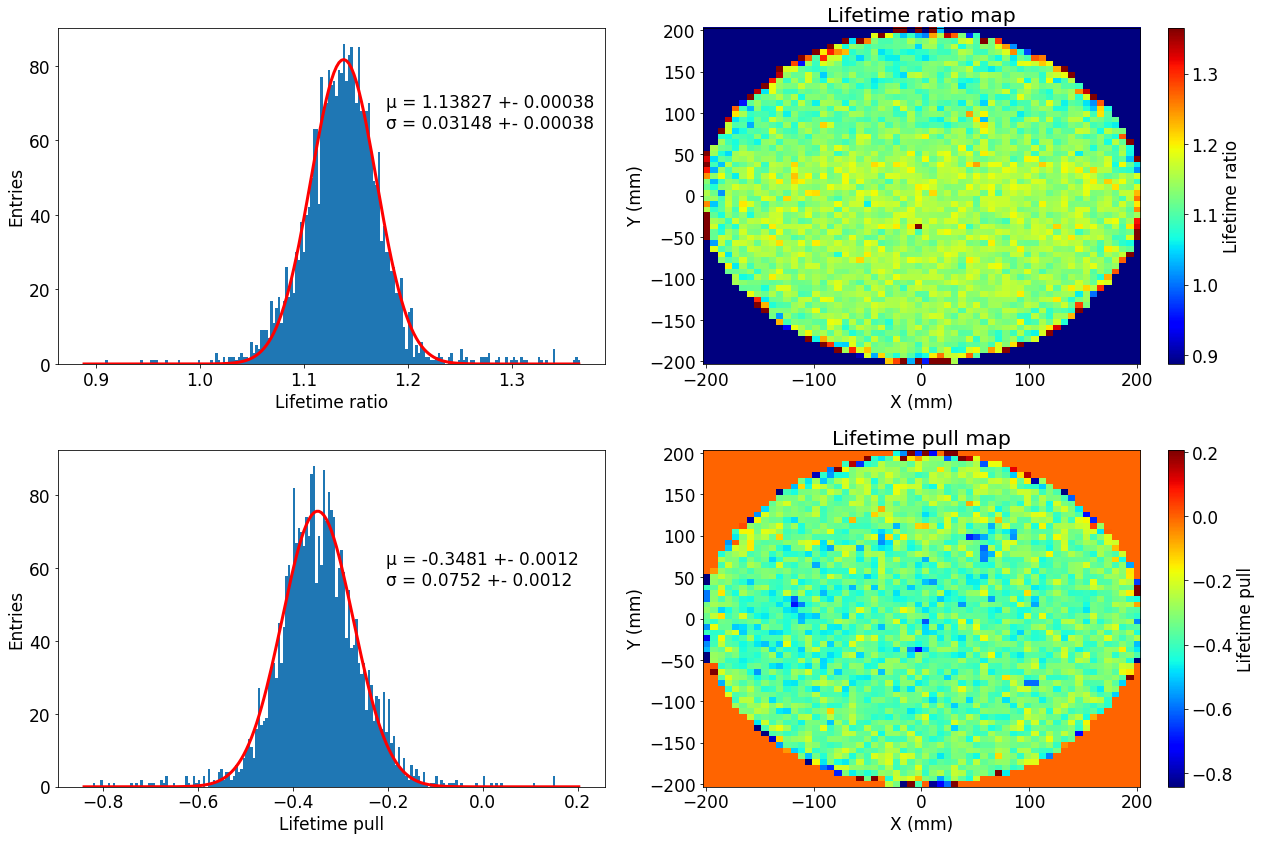

In [8]:
ratio_min  = np.median(LT_ratio) - 0.5 * np.std(LT_ratio)
ratio_max  = np.median(LT_ratio) + 0.5 * np.std(LT_ratio)
pull_min   = np.median(LT_pull)  - 3.0 * np.std(LT_pull)
pull_max   = np.median(LT_pull)  + 3.0 * np.std(LT_pull)


plt.figure()
plt.subplot(2, 2, 1)
y, x, _    = hist(LT_ratio.flatten(), np.linspace(ratio_min, ratio_max, 200), new_figure=False)
f          = fitf.fit(fitf.gauss, x, y, (1, 1, 1))
_, mu, sig = map(measurement_string, f.values, f.errors)

plt.plot(x, f.fn(x), "r-", lw=3)
plt.text(*text_coordinates(0.6, 0.7), f"µ = {mu}\nσ = {sig}")
labels("Lifetime ratio", "Entries")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(X, Y, LT_ratio,
                        vmin = ratio_min,
                        vmax = ratio_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Lifetime ratio")
labels("X (mm)", "Y (mm)", "Lifetime ratio map")

plt.subplot(2, 2, 3)
y, x, _    = hist(LT_pull[LT_pull != 0], np.linspace(pull_min, pull_max, 200), new_figure=False)
f          = fitf.fit(fitf.gauss, x, y, (1, 1, 1))
_, mu, sig = map(measurement_string, f.values, f.errors)

plt.plot(x, f.fn(x), "r-", lw=3)
plt.text(*text_coordinates(0.6, 0.6), f"µ = {mu}\nσ = {sig}")
labels("Lifetime pull", "Entries")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(X, Y, LT_pull,
                        vmin = pull_min,
                        vmax = pull_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Lifetime pull")
labels("X (mm)", "Y (mm)", "Lifetime pull map")

plt.tight_layout()

In [9]:
GEOmap_1 = dstf.load_dst(correction_filename_1,
                         group = "XYcorrections",
                         node  = f"Geometry_{XY_pitch:.1f}mm")

GEOmap_2 = dstf.load_dst(correction_filename_2,
                         group = "XYcorrections",
                         node  = f"Geometry_{XY_pitch:.1f}mm")

X   = np.unique(GEOmap_1.x.values)
Y   = np.unique(GEOmap_1.y.values)

GEO_1  = GEOmap_1.factor     .values.reshape(X.size, Y.size)
GEOu_1 = GEOmap_1.uncertainty.values.reshape(X.size, Y.size)
GEO_2  = GEOmap_2.factor     .values.reshape(X.size, Y.size)
GEOu_2 = GEOmap_2.uncertainty.values.reshape(X.size, Y.size)


GEO_ratio = ratio(GEO_2, GEO_1)
GEO_pull  = pull (GEO_2, GEO_1, GEOu_2, GEOu_1)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


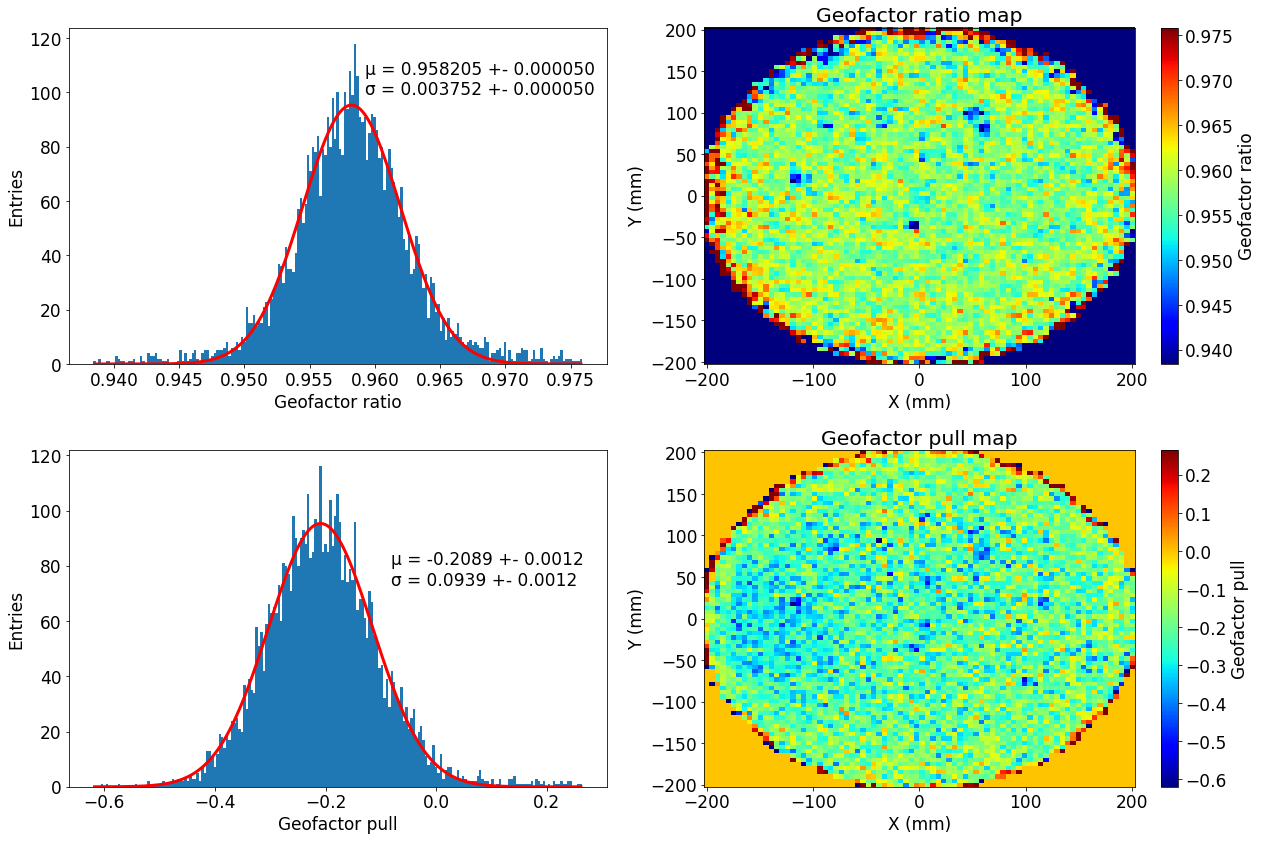

In [10]:
ratio_min  = np.median(GEO_ratio) - 0.05 * np.std(GEO_ratio)
ratio_max  = np.median(GEO_ratio) + 0.05 * np.std(GEO_ratio)
pull_min   = np.median(GEO_pull)  - 3.0 * np.std(GEO_pull)
pull_max   = np.median(GEO_pull)  + 3.0 * np.std(GEO_pull)


plt.figure()
plt.subplot(2, 2, 1)
y, x, _    = hist(GEO_ratio.flatten(), np.linspace(ratio_min, ratio_max, 200), new_figure=False)
f          = fitf.fit(fitf.gauss, x, y, (1, 1, 1))
_, mu, sig = map(measurement_string, f.values, f.errors)

plt.plot(x, f.fn(x), "r-", lw=3)
plt.text(*text_coordinates(0.55, 0.8), f"µ = {mu}\nσ = {sig}")
labels("Geofactor ratio", "Entries")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(X, Y, GEO_ratio,
                        vmin = ratio_min,
                        vmax = ratio_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Geofactor ratio")
labels("X (mm)", "Y (mm)", "Geofactor ratio map")

plt.subplot(2, 2, 3)
y, x, _    = hist(GEO_pull[GEO_pull != 0], np.linspace(pull_min, pull_max, 200), new_figure=False)
f          = fitf.fit(fitf.gauss, x, y, (1, 1, 1))
_, mu, sig = map(measurement_string, f.values, f.errors)

plt.plot(x, f.fn(x), "r-", lw=3)
plt.text(*text_coordinates(0.6, 0.6), f"µ = {mu}\nσ = {sig}")
labels("Geofactor pull", "Entries")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(X, Y, GEO_pull,
                        vmin = pull_min,
                        vmax = pull_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Geofactor pull")
labels("X (mm)", "Y (mm)", "Geofactor pull map")

plt.tight_layout()